In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Importing Libraries and Data

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

In [3]:
df=pd.read_csv("../input/titanic/train.csv")

In [4]:
test=pd.read_csv("../input/titanic/test.csv")

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Preprocessing

Checking various datatypes, this would help us identify anomalies in the data

In [6]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Checking if data with datatype-object is consistent. This will help us weed out nan values in the dataframe.

In [7]:
df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [8]:
df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [9]:
df['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8])

In [10]:
df['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6])

Dropping all the columns that will not substantially contribute to the result. Name, PassengerID, Ticket and Cabin are purely for the purpose of identification. Hence, they will not help us decipher trends.

In [11]:
df.drop('Name', inplace=True, axis=1)

In [12]:
df.drop('PassengerId', inplace=True, axis=1)

In [13]:

df.drop('Ticket', inplace=True, axis=1)
df.drop('Cabin', inplace=True, axis=1)

In [14]:
test.drop('Name', inplace=True, axis=1)
test.drop('PassengerId', inplace=True, axis=1)
test.drop('Ticket', inplace=True, axis=1)
test.drop('Cabin', inplace=True, axis=1)

In [15]:
df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})
test['Sex'] = test['Sex'].map({'female': 1, 'male': 0})

In [16]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S


In [17]:
df['Embarked'].isnull().values.sum()

2

In [44]:
df_no_miss=df[(df['Embarked'].notna())]
test=test[(test['Embarked'].notna())]

In [19]:
len(df_no_miss)

889

Splitting the data before we use it for training

In [20]:
x=df_no_miss.drop('Survived', axis=1)
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,S
1,1,1,38.0,1,0,71.2833,C
2,3,1,26.0,0,0,7.9250,S
3,1,1,35.0,1,0,53.1000,S
4,3,0,35.0,0,0,8.0500,S


In [21]:
y=df_no_miss['Survived'].copy()
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# One Hot Encoding

In [45]:
x_enc= pd.get_dummies(x,columns=['Sex','Embarked'])
test=pd.get_dummies(test,columns=['Sex','Embarked'])

In [23]:
x_enc.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_0,Sex_1,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,0,0,1
1,1,38.0,1,0,71.2833,0,1,1,0,0
2,3,26.0,0,0,7.9250,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,1,0,0,1
4,3,35.0,0,0,8.0500,1,0,0,0,1


In [24]:
df['Age'].isnull().values.sum()

177

In [25]:
df['Age'].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [47]:
x_enc['Age']=x_enc['Age'].fillna(0)
test['Age']=test['Age'].fillna(0)

In [27]:
x_enc['Age'].unique()


array([22.  , 38.  , 26.  , 35.  ,  0.  , 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [39]:
x_enc.isna().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_0         0
Sex_1         0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [49]:
test.isna().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          1
Sex_0         0
Sex_1         0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [50]:
test['Fare']=test['Fare'].fillna(0)

# Train-test Split

In [28]:
y.unique()

array([0, 1])

In [29]:
sum(y)/len(y)

0.38245219347581555

We use the stratify function in order to avoid imbalances in the testing and training data. As can be observed, it splits the data in the same proportion.

In [30]:
x_train, x_test, y_train, y_test= train_test_split(x_enc, y,stratify=y)

In [31]:
sum(y_train)/len(y_train)

0.38288288288288286

In [32]:
sum(y_test)/len(y_test)

0.3811659192825112

# XGBoost Classifier

In [33]:
cl_xgb=xgb.XGBClassifier(objective='binary:logistic', missing=1)
cl_xgb.fit(x_train, y_train, 
           verbose=True,
           early_stopping_rounds=10, 
           eval_metric='aucpr',
           eval_set=[(x_test, y_test)])

[0]	validation_0-aucpr:0.81041
[1]	validation_0-aucpr:0.81931
[2]	validation_0-aucpr:0.80013
[3]	validation_0-aucpr:0.80153
[4]	validation_0-aucpr:0.80618
[5]	validation_0-aucpr:0.80306
[6]	validation_0-aucpr:0.83372
[7]	validation_0-aucpr:0.83367
[8]	validation_0-aucpr:0.83426
[9]	validation_0-aucpr:0.83316
[10]	validation_0-aucpr:0.83962
[11]	validation_0-aucpr:0.83590
[12]	validation_0-aucpr:0.83291
[13]	validation_0-aucpr:0.82954
[14]	validation_0-aucpr:0.82445
[15]	validation_0-aucpr:0.82490
[16]	validation_0-aucpr:0.82268
[17]	validation_0-aucpr:0.82253


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-aucpr:0.82602
[19]	validation_0-aucpr:0.82471


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=1, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


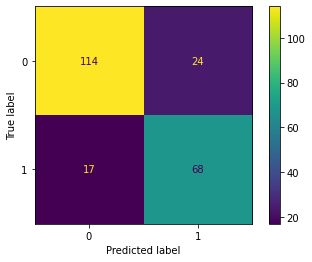

In [34]:
plot_confusion_matrix(cl_xgb,
                     x_test,
                     y_test,
                     values_format='d'
                     )

In [35]:
#param_grid={
#    'max_depth':[3,4,5],
   # 'learning_rate':[0.1,0.01,0.05],
   # 'gamma':[0.25, 0.5,1],
   # 'reg_lambda':[0,1,10],
    #'scale_pos_weight':[1,3,5]
#}
#opt_par= GridSearchCV(
#estimator=xgb.XGBClassifier(objective='binary:logistic',
#                          subsample=0.9,
#                         colsample_bytree=0.5),
#    param_grid=param_grid,
#   scoring='roc_auc',
#   verbose=0,
 #   n_jobs=10,
  #  cv=3
#)

In [36]:
#opt_par.fit(x_train, y_train, early_stopping_rounds=10,
 #          eval_metric='aucpr',
  #         eval_set=[(x_test,y_test)],
   #        verbose=False)

#print(opt_par.best_params_)

In [37]:
cl_xgb=xgb.XGBClassifier(objective='binary:logistic',
       gamma=1,
       learning_rate=0.05,
       max_depth=5,
       reg_lambda=10,
       scale_pos_weight=5,
       subsample=0.9,
       colsample_bytree=0.5)

cl_xgb.fit(x_train,
          y_train,
          verbose=True,
          early_stopping_rounds=10, 
          eval_metric='aucpr',
          eval_set=[(x_test, y_test)])

[0]	validation_0-aucpr:0.71549
[1]	validation_0-aucpr:0.71699
[2]	validation_0-aucpr:0.74184
[3]	validation_0-aucpr:0.74004
[4]	validation_0-aucpr:0.72210
[5]	validation_0-aucpr:0.80519
[6]	validation_0-aucpr:0.80674
[7]	validation_0-aucpr:0.81151
[8]	validation_0-aucpr:0.81255
[9]	validation_0-aucpr:0.80766
[10]	validation_0-aucpr:0.81377
[11]	validation_0-aucpr:0.81512
[12]	validation_0-aucpr:0.80933
[13]	validation_0-aucpr:0.80846
[14]	validation_0-aucpr:0.81050
[15]	validation_0-aucpr:0.81724
[16]	validation_0-aucpr:0.81139
[17]	validation_0-aucpr:0.81427
[18]	validation_0-aucpr:0.81807
[19]	validation_0-aucpr:0.81992
[20]	validation_0-aucpr:0.81935


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21]	validation_0-aucpr:0.81937
[22]	validation_0-aucpr:0.82101
[23]	validation_0-aucpr:0.81865
[24]	validation_0-aucpr:0.81766
[25]	validation_0-aucpr:0.81810
[26]	validation_0-aucpr:0.81956
[27]	validation_0-aucpr:0.81952
[28]	validation_0-aucpr:0.81964
[29]	validation_0-aucpr:0.82044
[30]	validation_0-aucpr:0.82147
[31]	validation_0-aucpr:0.82126
[32]	validation_0-aucpr:0.82034
[33]	validation_0-aucpr:0.82063
[34]	validation_0-aucpr:0.81883
[35]	validation_0-aucpr:0.81842
[36]	validation_0-aucpr:0.81873
[37]	validation_0-aucpr:0.81914
[38]	validation_0-aucpr:0.81392
[39]	validation_0-aucpr:0.81444


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=5, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


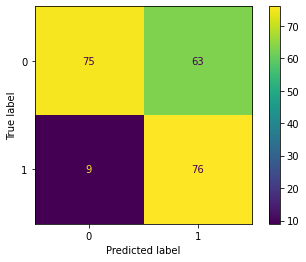

In [53]:
plot_confusion_matrix(cl_xgb,
                     x_test,
                     y_test,
                     values_format='d'
                     )

[09:49:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight: {'Sex_0': 1, 'Parch': 2, 'Pclass': 1, 'Age': 6, 'Embarked_Q': 1}
gain: {'Sex_0': 185.828369, 'Parch': 13.959426875000002, 'Pclass': 54.086235, 'Age': 10.002540233333333, 'Embarked_Q': 5.07331276}
cover: {'Sex_0': 372.0, 'Parch': 158.375, 'Pclass': 181.25, 'Age': 47.291666666666664, 'Embarked_Q': 21.0}
total_gain: {'Sex_0': 185.828369, 'Parch': 27.918853750000004, 'Pclass': 54.086235, 'Age': 60.015241399999994, 'Embarked_Q': 5.07331276}
total_cover: {'Sex_0': 372.0, 'Parch': 316.75, 'Pclass': 181.25, 'Age': 283.75, 'Embarked_Q': 21.0}


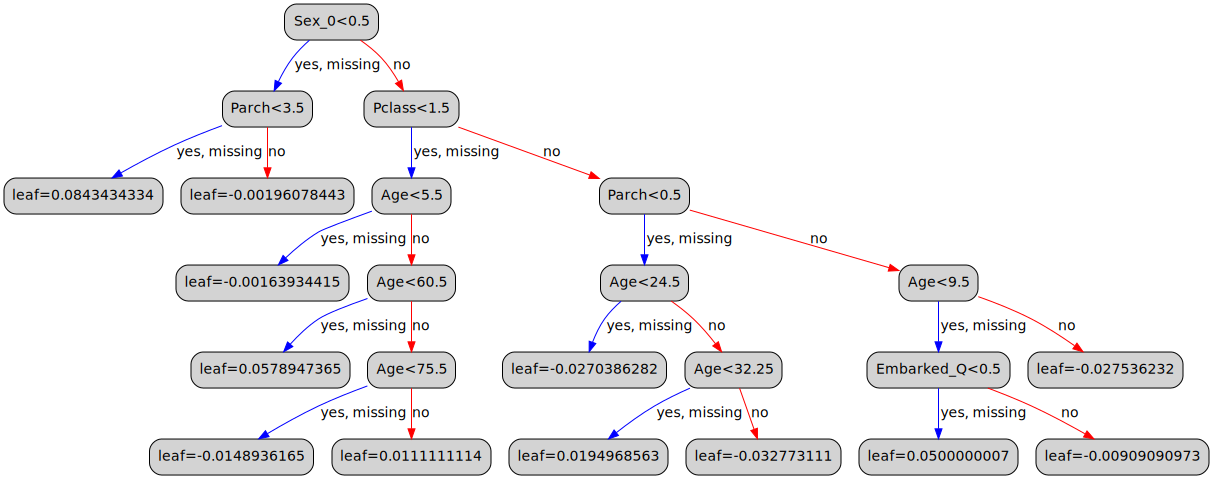

In [38]:
cl_xgb=xgb.XGBClassifier(objective='binary:logistic',
       gamma=1,
       learning_rate=0.05,
       max_depth=5,
       reg_lambda=10,
       scale_pos_weight=5,
       subsample=0.9,
       colsample_bytree=0.5,
       n_estimators=1)

cl_xgb.fit(x_train,
          y_train)
bstr=cl_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s:'%importance_type, bstr.get_score(importance_type=importance_type))
node_par={'shape':'box',
           'style':'filled, rounded'}
leaf_par={'shape':'box',
           'style':'filled, rounded'}
xgb.to_graphviz(cl_xgb, num_trees=0, size="5,5", 
               condition_node_params=node_par,
               leaf_node_params=leaf_par)

# Linear Support Vector Classifier

In [42]:
svc = LinearSVC(max_iter=10000,dual=True)
svc.fit(x_train, y_train)

pred = svc.predict(x_test)

acc_svc = round(svc.score(x_train, y_train) * 100, 2)
acc_svc

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


78.23

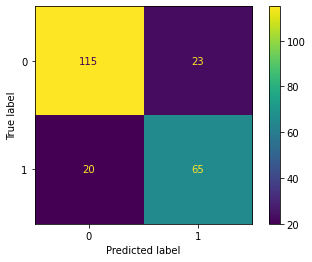

In [54]:
plot_confusion_matrix(svc,
                     x_test,
                     y_test,
                     values_format='d'
                     )

# Decision Tree Classifier

In [51]:
dec = DecisionTreeClassifier()
dec.fit(x_enc, y)
dec_pred = dec.predict(test)
acc_dec= round(dec.score(x_enc,y) * 100, 2)
acc_dec

98.2

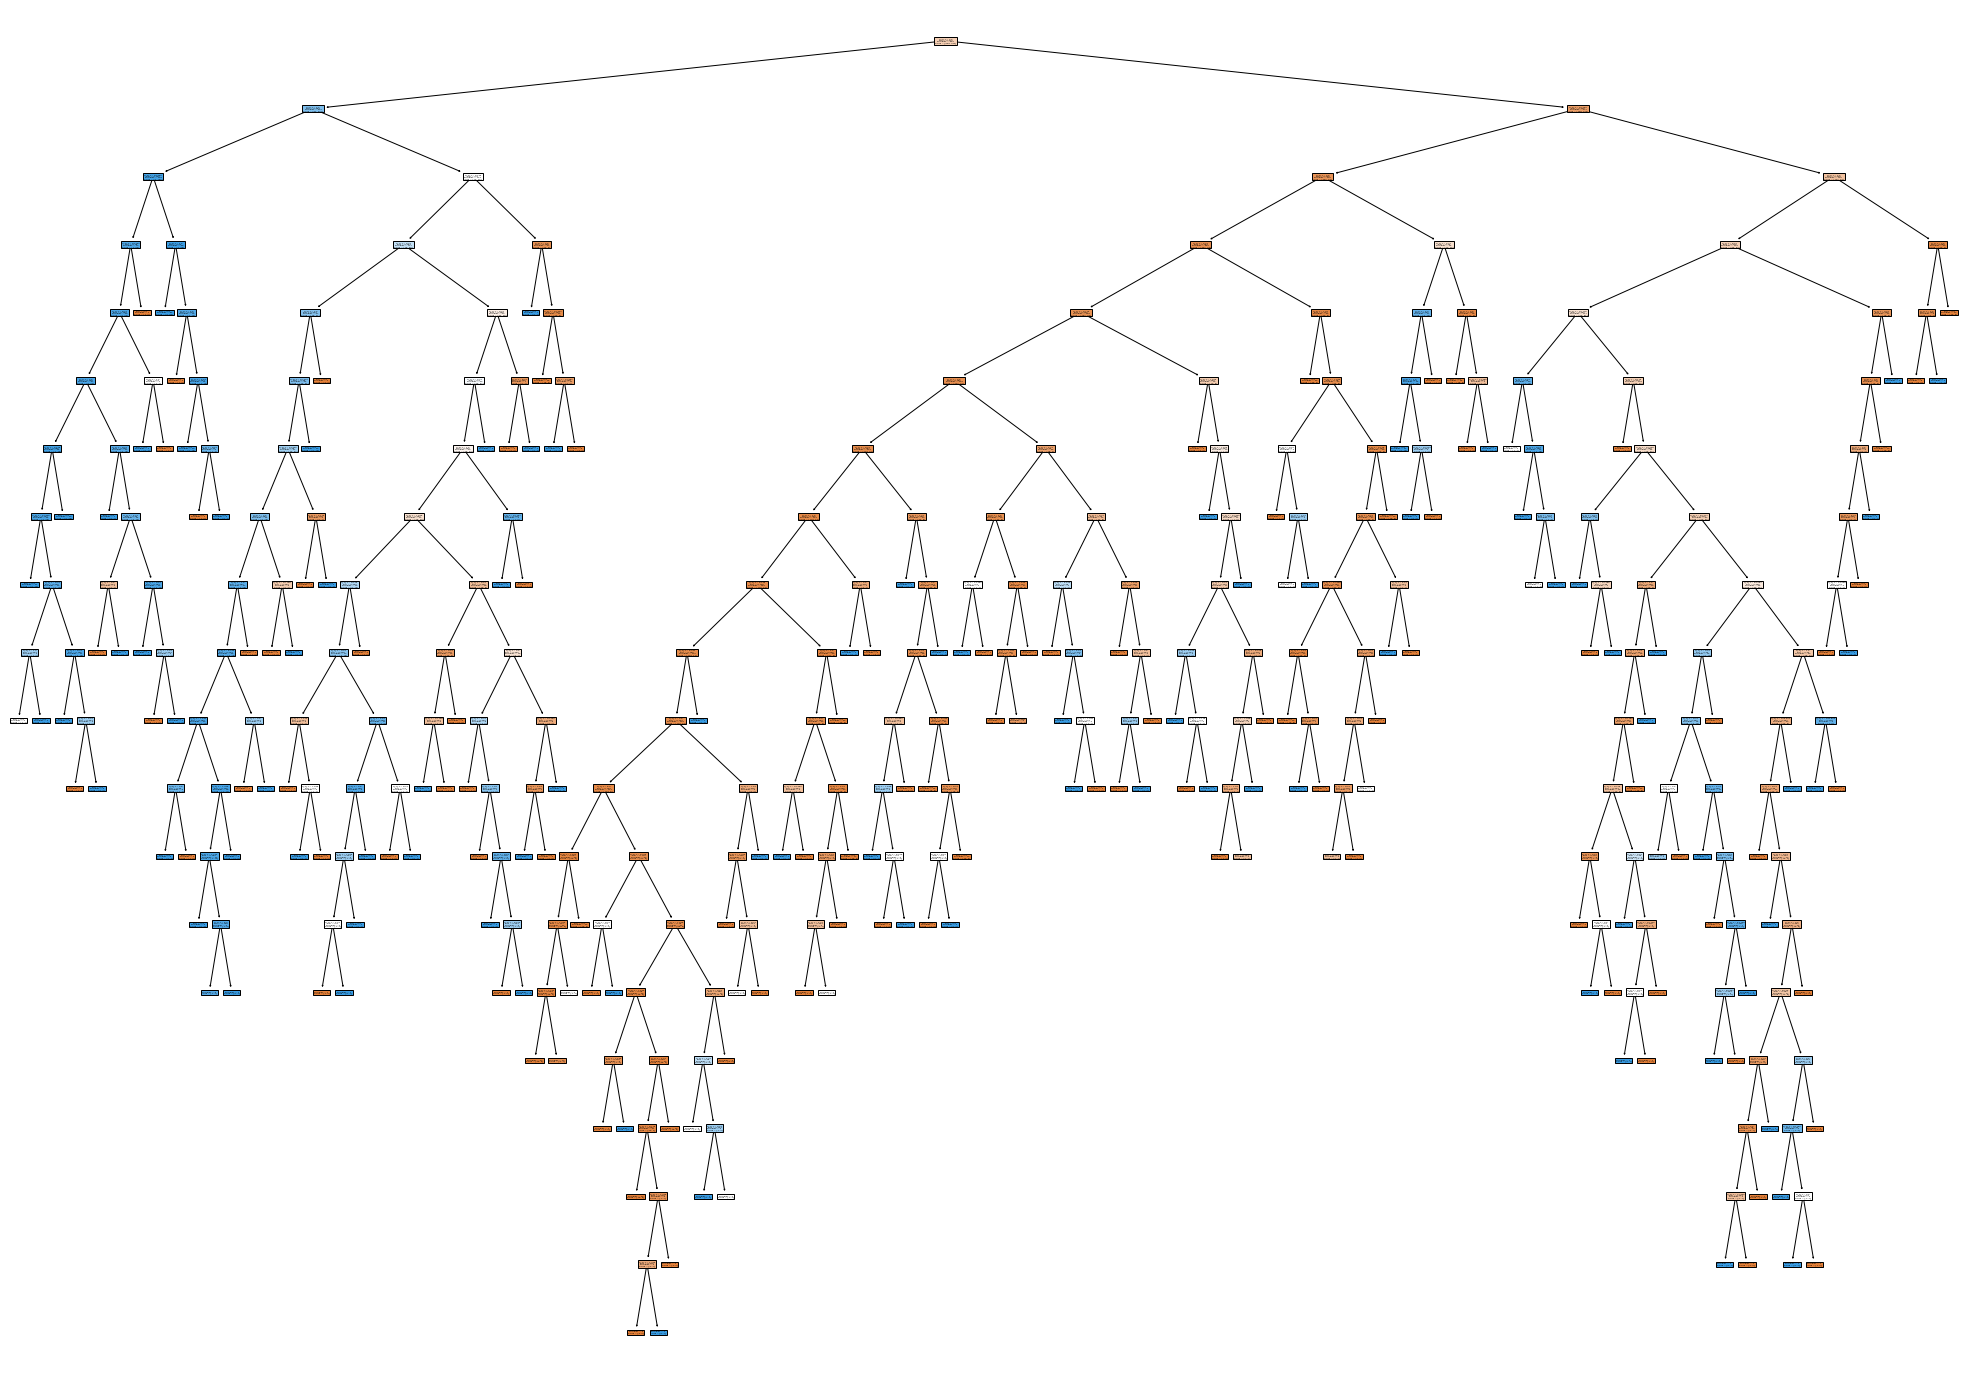

In [63]:
from sklearn import tree
fig = plt.figure(figsize=(35,25))
_ = tree.plot_tree(dec, 
                   filled=True)

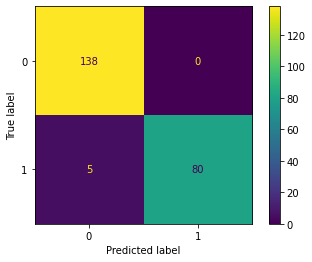

In [55]:
plot_confusion_matrix(dec,
                     x_test,
                     y_test,
                     values_format='d'
                     )

# Random Forest Classifier

In [52]:
random_forest = RandomForestClassifier(criterion = "entropy", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 1,
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=42, 
                                       n_jobs=-1)

random_forest.fit(x_train, y_train)
pred_rf = random_forest.predict(x_test)

random_forest.score(x_train, y_train)

0.9069069069069069

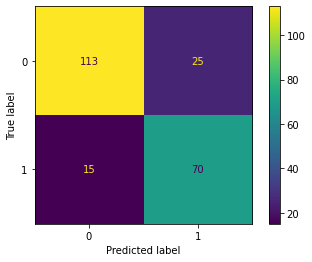

In [68]:
plot_confusion_matrix(random_forest,
                     x_test,
                     y_test,
                     values_format='d'
                     )

In [80]:
submission=pd.read_csv('../input/titanic/gender_submission.csv')

In [81]:
final_pred=random_forest.predict(test)

In [82]:
submission['Survived']=final_pred

In [83]:
pd.DataFrame(submission,columns=['PassengerId','Survived']).to_csv('titanic_new.csv',index=False)

In [84]:
pd.read_csv('titanic_new.csv')

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
